In [74]:
import imageio
from requests import get
from datetime import datetime
from opensky_api import OpenSkyApi
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from json import loads
from shapely.geometry import shape, Point
import geopandas as gpd
import osmnx as ox
import pandas as pd
import mplcyberpunk
plt.style.use("cyberpunk")

In [2]:
AMTRAK_URL = "https://api-v3.amtraker.com/v3/trains"
amtrak_data = loads(get(AMTRAK_URL).text)
api = OpenSkyApi()
with open("./us_boundaries.json", "r") as doc:
    us_bounds = shape(loads(doc.read())["features"][0]["geometry"])

In [78]:
ALT_FAC = .5
def get_in_progress_paths(box=(15, 70, -135, -65), only_first=None, alt_fac=ALT_FAC):
    states = api.get_states(bbox=box)
    crafts = sorted(set([s.icao24 for s in states.states]))
    tracks = [api.get_track_by_aircraft(c) for c in tqdm(list(crafts)[:only_first])]
    paths = [{
        "icao24": t.icao24,
        "callsign": t.callsign,
        "time": [i[0] for i in t.path],
        "lats": [i[1] for i in t.path],
        "longs": [i[2] for i in t.path],
        "alts": [i[3] * alt_fac for i in t.path]
    } for t in filter(lambda x: x is not None, tracks)]
    return [np.array([p["lats"], p["longs"], p["alts"]]) for p in paths]

def get_paths_at_time(time, box=(15, 70, -135, -65), only_first=None, alt_fac=ALT_FAC, expire=1e6):
    states = api.get_states(bbox=box)
    crafts = sorted(set([s.icao24 for s in states.states]))
    tracks = [api.get_track_by_aircraft(c) for c in tqdm(list(crafts)[:only_first])]
    paths = [{
        "icao24": t.icao24,
        "callsign": t.callsign,
        "time": [i[0] for i in t.path],
        "lats": [i[1] for i in t.path],
        "longs": [i[2] for i in t.path],
        "alts": [i[3] * alt_fac for i in t.path]
    } for t in filter(lambda x: x is not None, tracks)]
    t = time
    return [np.array([np.array(p["lats"])[idx], np.array(p["longs"])[idx], np.array(p["alts"])[idx]]) for p in paths if np.sum((idx := ((np.array(p["time"]) <= t) & ((t - expire) <= np.array(p["time"]))))) > 0]

def get_timed_paths(box=(15, 70, -135, -65), only_first=None, alt_fac=ALT_FAC, expire=1e6):
    states = api.get_states(bbox=box)
    crafts = sorted(set([s.icao24 for s in states.states]))
    tracks = [api.get_track_by_aircraft(c) for c in tqdm(list(crafts)[:only_first])]
    paths = [{
        "icao24": t.icao24,
        "callsign": t.callsign,
        "time": [i[0] for i in t.path],
        "lats": [i[1] for i in t.path],
        "longs": [i[2] for i in t.path],
        "alts": [i[3] * alt_fac for i in t.path]
    } for t in filter(lambda x: x is not None, tracks)]
    times = np.unique(np.concatenate([i["time"] for i in paths]))
    interval = (np.min(times), np.max(times))
    times = np.linspace(*interval, num=len(times))
    return [[np.array([np.array(p["lats"])[idx], np.array(p["longs"])[idx], np.array(p["alts"])[idx]]) for p in paths if np.sum((idx := ((np.array(p["time"]) <= t) & ((t - expire) <= np.array(p["time"]))))) > 0] for t in times]

def get_mask(oob):
    m = []
    cur = True
    for i in oob:
        if cur is None:
            m.append(False)
            continue
        if cur:
            if i:
                m.append(False)
            else:
                cur = False
                m.append(True)
        else:
            if i:
                cur = None
                m.append(False)
            else:
                m.append(True)
    return m

def freeze_oob(flights, box=(15, 70, -135, -65), timed=False):
    res = []
    for f in flights:
        if len(f) == 0:
            continue
        if timed:
            _f = f[-1]
        else:
            _f = f
        latoob = (_f[0] < box[0]) | (box[1] < _f[0])
        longoob = (_f[1] < box[2]) | (box[3] < _f[1])
        oob = [False, False]#latoob | longoob
        m = get_mask(oob)
        if len(_f[0]) < 3:
            continue
        if np.all(m) and np.max(np.abs(_f[0, 1:] - _f[0, :-1])) < 2.5 and np.max(np.abs(_f[1, 1:] - _f[1, :-1])) < 5:
            res.append(f)
    return res

In [4]:
#THANKS TO https://github.com/ColCarroll/ridge_map
#THIS CODE COMES FROM THERE WITH SIGNIFICANT MODIFICATIONS
"""3D maps with 1D lines."""

from urllib.request import urlopen
from tempfile import NamedTemporaryFile

from matplotlib.collections import LineCollection
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import rank
from skimage.morphology import square
from skimage.util import img_as_ubyte

import srtm


class FontManager:
    """Utility to load fun fonts from https://fonts.google.com/ for matplotlib.

    Find a nice font at https://fonts.google.com/, and then get its corresponding URL
    from https://github.com/google/fonts/

    Use like:

    fm = FontManager()
    fig, ax = plt.subplots()

    ax.text("Good content.", fontproperties=fm.prop, size=60)
    """

    def __init__(
        self,
        github_url="https://github.com/google/fonts/raw/main/ofl/cinzel/Cinzel%5Bwght%5D.ttf",  # pylint: disable=line-too-long
    ):
        """
        Lazily download a font.

        Parameters
        ----------
        github_url : str
            Can really be any .ttf file, but probably looks like
            "https://github.com/google/fonts/raw/main/ofl/cinzel/Cinzel%5Bwght%5D.ttf" # pylint: disable=line-too-long
        """
        self.github_url = github_url
        self._prop = None

    @property
    def prop(self):
        """Get matplotlib.font_manager.FontProperties object that sets the custom font."""
        if self._prop is None:
            with NamedTemporaryFile(delete=False, suffix=".ttf") as temp_file:
                # pylint: disable=consider-using-with
                temp_file.write(urlopen(self.github_url).read())
                self._prop = fm.FontProperties(fname=temp_file.name)
        return self._prop


class RidgeMap:
    """Main class for interacting with art.

    Keeps state around so no servers are hit too often.
    """

    def __init__(self, bbox=(-71.928864, 43.758201, -70.957947, 44.465151), font=None):
        """Initialize RidgeMap.

        Parameters
        ----------
        bbox : list-like of length 4
            In the form (long, lat, long, lat), describing the
            (bottom_left, top_right) corners of a box.
            http://bboxfinder.com is a useful way to find these tuples.
        font : matplotlib.font_manager.FontProperties
            Optional, a custom font to use. Defaults to Cinzel Regular.
        """
        self.bbox = bbox
        self._srtm_data = srtm.get_data()
        if font is None:
            font = FontManager().prop
        self.font = font
        self.mask = None

    @property
    def lats(self):
        """Left and right latitude of bounding box."""
        return (self.bbox[1], self.bbox[3])

    @property
    def longs(self):
        """Bottom and top longitude of bounding box."""
        return (self.bbox[0], self.bbox[2])

    def get_elevation_data(self, num_lines=80, elevation_pts=300, viewpoint="south"):
        """Fetch elevation data and return a numpy array.

        Parameters
        ----------
        num_lines : int
            Number of horizontal lines to draw
        elevation_pts : int
            Number of points on each line to request. There's some limit to
            this that srtm enforces, but feel free to go for it!
        viewpoint : str in ["south", "west", "north", "east"] (default "south")
            The compass direction from which the map will be visualised.

        Returns
        -------
        np.ndarray
        """
        if viewpoint in ["east", "west"]:
            num_lines, elevation_pts = elevation_pts, num_lines
        values = self._srtm_data.get_image(
            (elevation_pts, num_lines), self.lats, self.longs, 5280, mode="array"
        )

        switch = {"south": 0, "west": 3, "north": 2, "east": 1}
        rotations = switch[viewpoint]
        values = np.rot90(m=values, k=rotations)
        return values
    
    def build_bound_mask(self, values, bounds, verbose=False):
        if verbose:
            _tqdm = tqdm
        else:
            _tqdm = lambda x: x
        inverse_lat = lambda _x: ((_x/values.shape[0])*(self.lats[0] - self.lats[1])) + self.lats[1]
        inverse_long = lambda _x: ((_x/values.shape[1])*(self.longs[0] - self.longs[1])) + self.longs[1]
        lats = inverse_lat(np.arange(values.shape[0]))
        longs = inverse_long(np.arange(values.shape[1]))
        lats, longs = np.meshgrid(lats, longs)
        geometry = bounds
        geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=5)
        gdf_nodes = gpd.GeoDataFrame(data={'x':longs.reshape((-1,)), 'y':lats.reshape((-1,))})
        gdf_nodes.name = 'nodes'
        gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)
        sindex = gdf_nodes.sindex
        points_within_geometry = pd.DataFrame()
        for poly in _tqdm(geometry_cut.geoms):
            # buffer by the <1 micron dist to account for any space lost in the quadrat cutting
            # otherwise may miss point(s) that lay directly on quadrat line
            poly = poly.buffer(1e-14).buffer(0)

            # find approximate matches with r-tree, then precise matches from those approximate ones
            possible_matches_index = list(sindex.intersection(poly.bounds))
            possible_matches = gdf_nodes.iloc[possible_matches_index]
            precise_matches = possible_matches[possible_matches.intersects(poly)]
            points_within_geometry = pd.concat([points_within_geometry, precise_matches])#points_within_geometry = points_within_geometry.append(precise_matches)
        points_within_geometry = points_within_geometry.drop_duplicates(subset=['x', 'y'])
        points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]
        m = np.zeros_like(values)
        for r in _tqdm(range(values.shape[0])):
            for c in range(values.shape[1]):
                if np.any(((points_outside_geometry["x"] == longs.T[r][c]) & (points_outside_geometry["y"] == lats.T[r][c])).values):
                    m[r][-1 - c] = np.nan
        return m

    def preprocess(
        self, *, values=None, water_ntile=10, lake_flatness=3, vertical_ratio=40, bounds=None
    ):
        """Get map data ready for plotting.

        You can do this yourself, and pass an array directly to plot_map. This
        gathers all nan values, the lowest `water_ntile` percentile of elevations,
        and anything that is flat enough, and sets the values to `nan`, so no line
        is drawn. It also exaggerates the vertical scale, which can be nice for flat
        or mountainy areas.

        Parameters
        ----------
        values : np.ndarray
            An array to process, or fetch the elevation data lazily here.
        water_ntile : float in [0, 100]
            Percentile below which to delete data. Useful for coasts or rivers.
            Set to 0 to not delete any data.
        lake_flatness : int
            How much the elevation can change within 3 squares to delete data.
            Higher values delete more data. Useful for rivers, lakes, oceans.
        vertical_ratio : float > 0
            How much to exaggerate hills. Kind of arbitrary. 40 is reasonable,
            but try bigger and smaller values!

        Returns
        -------
        np.ndarray
            Processed data.
        """
        if values is None:
            values = self.get_elevation_data()
        nan_vals = np.isnan(values)

        values[nan_vals] = np.nanmin(values)
        self.minv = np.min(values)
        self.maxv = np.max(values)
        self.vertical_ratio = vertical_ratio
        values = (values - self.minv) / (self.maxv - self.minv)

        is_water = values < np.percentile(values, water_ntile)
        is_lake = rank.gradient(img_as_ubyte(values), square(3)) < lake_flatness

        values[nan_vals] = np.nan
        values[np.logical_or(is_water, is_lake)] = np.nan
        values = vertical_ratio * values[-1::-1]  # switch north and south
        if bounds is not None:
            if self.mask is None:
                m = self.build_bound_mask(values, bounds)
                self.mask = m
            else:
                m = self.mask
            values += m
        return values
    
    def approx_elevation(self, lat, long, values):
        return values[int(lat), int(long)]
    
    # pylint: disable=too-many-arguments,too-many-locals
    def plot_map_with_extra_lines(
        self,
        values=None,
        extra_lines=[],#should be a list of 3x? arrays with [[lat], [long], [elev]] (if elev is None, elev is inferred as ground level)
        label="The White\nMountains",
        label_x=0.62,
        label_y=0.15,
        label_verticalalignment="bottom",
        label_size=60,
        line_color="black",
        kind="gradient",
        linewidth=2,
        background_color=(0.9255, 0.9098, 0.9255),
        size_scale=20,
        ax=None,
        experimental_zorder=True,
        no_label=True,
        verbose=False,
        plane_color=None,
        plane_width=None
    ):
        """Plot the map.

        Lots of nobs, and they're all useful to sometimes turn.

        Parameters
        ----------
        values : np.ndarray
            Array of elevations to plot. Defaults to the elevations at the provided
            bounding box.
        label : string
            Label to place on the map. Use an empty string for no label.
        label_x : float in [0, 1]
            Where to position the label horizontally
        label_y : float in [0, 1]
            Where to position the label vertically
        label_verticalalignment: "top" or "bottom"
            Whether the label_x and label_y refer to the top or bottom left corner
            of the label text box
        label_size : int
            fontsize of the label
        line_color : string or callable
            colors for the map. A callable will be fed the scaled index in [0, 1]
        kind : {"gradient" | "elevation"}
            If you provide a colormap to `line_color`, "gradient" colors by the line index, and
            "elevation" colors by the actual elevation along the line.
        linewidth : float
            Width of each line in the map
        background_color : color
            For the background of the map and figure
        scale_size : float
            If you are printing this, make this number bigger.
        ax : matplotlib Axes
            You can pass your own axes!

        Returns
        -------
        matplotlib.Axes
        """
        if plane_color is None:
            plane_color = line_color
        if plane_width is None:
            plane_width = linewidth
        if kind not in {"gradient", "elevation"}:
            raise TypeError("Argument `kind` must be one of 'gradient' or 'elevation'")
        if values is None:
            values = self.preprocess()

        if ax is None:
            ratio = (self.lats[1] - self.lats[0]) / (self.longs[1] - self.longs[0])
            _, ax = plt.subplots(figsize=(size_scale, size_scale * ratio))

        x = np.arange(values.shape[1])
        norm = plt.Normalize(np.nanmin(values), np.nanmax(values))

        lats_norm = lambda _x: -values.shape[0] * (_x - self.lats[1])/(self.lats[1] - self.lats[0])
        longs_norm = lambda _x: values.shape[1] * (_x - self.longs[0])/(self.longs[1] - self.longs[0])
        elevs_norm = lambda _x: self.vertical_ratio * ((_x - self.minv) / (self.maxv - self.minv))
        extra_lines = [np.array([
            i[0],
            i[1],
            np.array([
                (elevs_norm(_i) if _i is not None else self.approx_elevation(
                    lats_norm(i[0][n]),
                    longs_norm(i[1][n]),
                    values
                )) for n, _i in enumerate(i[2])
            ])])
            for i in extra_lines
        ]
        if verbose:
            print(extra_lines)
        for idx, (lats, longs, elevs) in enumerate(extra_lines):
            _lats = lats_norm(lats)
            _longs = longs_norm(longs)
            y_base = -6 * _lats * np.ones_like(elevs)
            _y = elevs + y_base
            _x = _longs
            if callable(plane_color) and kind == "elevation":
                points = np.array([_x, _y]).T.reshape((-1, 1, 2))
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                if experimental_zorder:
                    for n, seg in enumerate(segments):
                        color = plane_color(norm(elevs[n]))
                        l = ax.plot(seg[:, 0], seg[:, 1], "-", c=color, zorder=_lats[n], lw=plane_width)
                        #mplcyberpunk.add_gradient_fill(l[0], alpha_gradientglow=.5, gradient_start="min")
                else:
                    lines = LineCollection(
                        segments, cmap=plane_color, zorder=idx, norm=norm
                    )
                    lines.set_array(elevs)
                    lines.set_linewidth(plane_width)
                    ax.add_collection(lines)
            else:
                if callable(plane_color) and kind == "gradient":
                    color = plane_color(_lats[0] / values.shape[0])
                else:
                    color = plane_color
                if experimental_zorder:
                    points = np.array([_x, _y]).T.reshape((-1, 1, 2))
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    for n, seg in enumerate(segments):
                        if callable(plane_color) and kind == "gradient":
                            color = plane_color(_lats[n] / values.shape[0])
                        l = ax.plot(seg[:, 0], seg[:, 1], "-", c=color, zorder=_lats[n])
                        #mplcyberpunk.add_gradient_fill(l[0], alpha_gradientglow=.5, gradient_start="min")
                else:
                    ax.plot(_x, _y, "-", color=color, zorder=_lats[0], lw=plane_width)
            #ax.fill_between(x, y_base, y, color=background_color, zorder=idx)
        mplcyberpunk.add_gradient_fill(alpha_gradientglow=.5, gradient_start="bottom")
        
        for idx, row in enumerate(values):
            y_base = -6 * idx * np.ones_like(row)
            y = row + y_base
            if callable(line_color) and kind == "elevation":
                points = np.array([x, y]).T.reshape((-1, 1, 2))
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lines = LineCollection(
                    segments, cmap=line_color, zorder=idx + 1, norm=norm
                )
                lines.set_array(row)
                lines.set_linewidth(linewidth)
                ax.add_collection(lines)
            else:
                if callable(line_color) and kind == "gradient":
                    color = line_color(idx / values.shape[0])
                else:
                    color = line_color

                ax.plot(x, y, "-", color=color, zorder=idx, lw=linewidth)
            ax.fill_between(x, y_base - 1500, y, color=background_color, zorder=idx)
            ax.fill_between(np.concatenate([x[:1] - 1000, x, x[-1:] + 1000]), np.concatenate([(y_base - 1500)[:1], (y_base - 1500), (y_base - 1500)[-1:]]), np.concatenate([(y_base - 20)[:1], (y_base - 20), (y_base - 20)[-1:]]), color=background_color, zorder=idx)

        if not no_label:
            ax.text(
                label_x,
                label_y,
                label,
                transform=ax.transAxes,
                fontproperties=self.font,
                size=label_size,
                verticalalignment=label_verticalalignment,
                bbox={"facecolor": background_color, "alpha": 1, "linewidth": 0},
                zorder=len(values) + 10,
            )

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_facecolor(background_color)
        ax.set_ylim((-1665.1464022797436, -275.9255521253859))
        ax.set_xlim((5.199999999999999, 264.8))
        return ax

In [5]:
_box = (-125, 24, -66, 49)
box = _box[1::2] + _box[::2]
_box = (-129, 15, -56, 56)#(-135, 15, -56, 56)

rm = RidgeMap(_box)
try:
    values
except:
    values = rm.get_elevation_data(num_lines=350)

In [6]:
_flights = get_in_progress_paths(box=box, only_first=100, alt_fac=ALT_FAC)

python(7765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [7]:
flights = freeze_oob(_flights, box=box)

In [60]:
__times = get_timed_paths(box=box, only_first=100, alt_fac=ALT_FAC, expire=3600)

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


In [67]:
_times = freeze_oob(__times, box=box, timed=True)

In [80]:
_cur_paths = get_paths_at_time(datetime.utcnow(), box=box, alt_fac=ALT_FAC, only_first=500, expire=3600)

ReadTimeout: HTTPSConnectionPool(host='opensky-network.org', port=443): Read timed out. (read timeout=15.0)

In [ ]:
cur_paths = freeze_oob(_cur_paths, box=box)

NameError: name '_cur_paths' is not defined

In [10]:
VERTICAL_RATIO = 50#30#25#50
def make_plot(values, flights, path=None):
    _v = rm.preprocess(values=values, lake_flatness=1, water_ntile=37, vertical_ratio=VERTICAL_RATIO, bounds=us_bounds)
    ax = rm.plot_map_with_extra_lines(
        values=_v,
        extra_lines=flights,
        no_label=True,
        experimental_zorder=True,
        line_color=plt.get_cmap("spring"),
        background_color=(33/255, 41/255, 70/255),
        linewidth=3,
        plane_width=4
    )
    plt.style.use("cyberpunk")
    mplcyberpunk.make_lines_glow(ax)
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    return ax

/opt/miniconda3/envs/background/lib/python3.9/site-packages/mplcyberpunk/core.py:186: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(z,


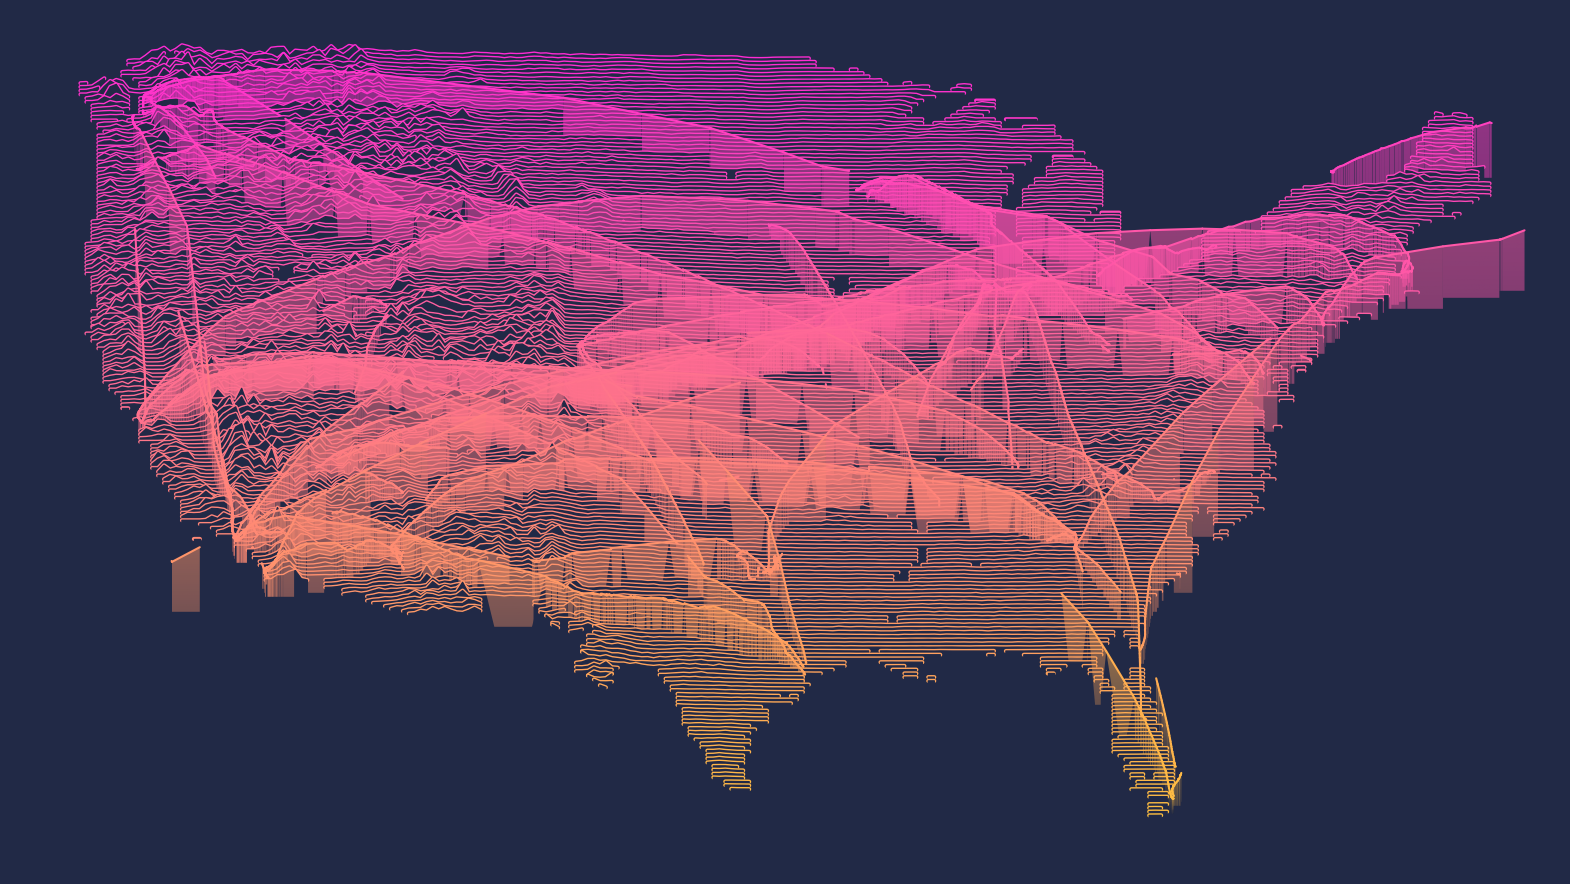

In [ ]:
ax = make_plot(values, flights)
plt.show()

In [ ]:
ax = make_plot(values, cur_paths)
plt.show()

In [68]:
def make_gif(values, _t, duration=10):
    filenames = []
    for n, t in tqdm(list(enumerate(_t))):
        filenames.append("./gif/{}.png".format(n))
        make_plot(values, t, path=filenames[-1])
        plt.close()
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('./flights.gif', images, duration=duration/len(filename))

In [69]:
make_gif(values, _times[::100])

100%|██████████| 37/37 [05:54<00:00,  9.57s/it]
/var/folders/74/r8z4mzzj53q1bg1hy3nn2hlh0000gn/T/ipykernel_7737/292291511.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
